# Import

## Modules

In [176]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Data

In [146]:
raw_cases_data = pd.read_csv('https://data.nsw.gov.au/data/dataset/97ea2424-abaf-4f3e-a9f2-b5c883f42b6a/resource/2776dbb8-f807-4fb2-b1ed-184a6fc2c8aa/download/confirmed_cases_table4_location_likely_source.csv')
raw_tests_data = pd.read_csv("https://data.nsw.gov.au/data/dataset/5424aa3b-550d-4637-ae50-7f458ce327f4/resource/227f6b65-025c-482c-9f22-a25cf1b8594f/download/covid-19-tests-by-date-and-location-and-result.csv")



# Preprocessing

In [147]:
raw_cases_data["notification_date"] = pd.to_datetime(raw_cases_data["notification_date"])
raw_tests_data["test_date"] = pd.to_datetime(raw_tests_data["test_date"])

# Subset

In [148]:
cases_df = raw_cases_data.query("notification_date >= '2021-06-01' & likely_source_of_infection != 'Overseas'")

# Cases Analysis

In [207]:
cases_agg = cases_df.groupby("notification_date").count().iloc[:, 0].to_frame(name="Count")
cases_agg.reset_index(inplace=True)
cases_agg.sort_values(by="notification_date", inplace=True, ascending=True)
cases_agg["Cumsum"] = cases_agg["Count"].cumsum()
cases_agg["Daily Pct Change"] = 100*cases_agg["Count"].pct_change()
cases_agg["Daily Difference"] = cases_agg["Count"].diff()
cases_agg["Average"] = cases_agg["Count"].rolling(window=7).mean()
cases_agg["Normalized"] = cases_agg["Average"] / cases_agg["Average"].max()

In [277]:
idx = cases_agg['Cumsum'].sub(100).abs().idxmin()
cases_agg["Epidemiological Days"]  = (cases_agg["notification_date"] - cases_agg.loc[idx, "notification_date"]) / np.timedelta64(1, 'D')

## Daily Nnumber of Cases

Text(0.5, 1.0, 'Daily Number of Cases')

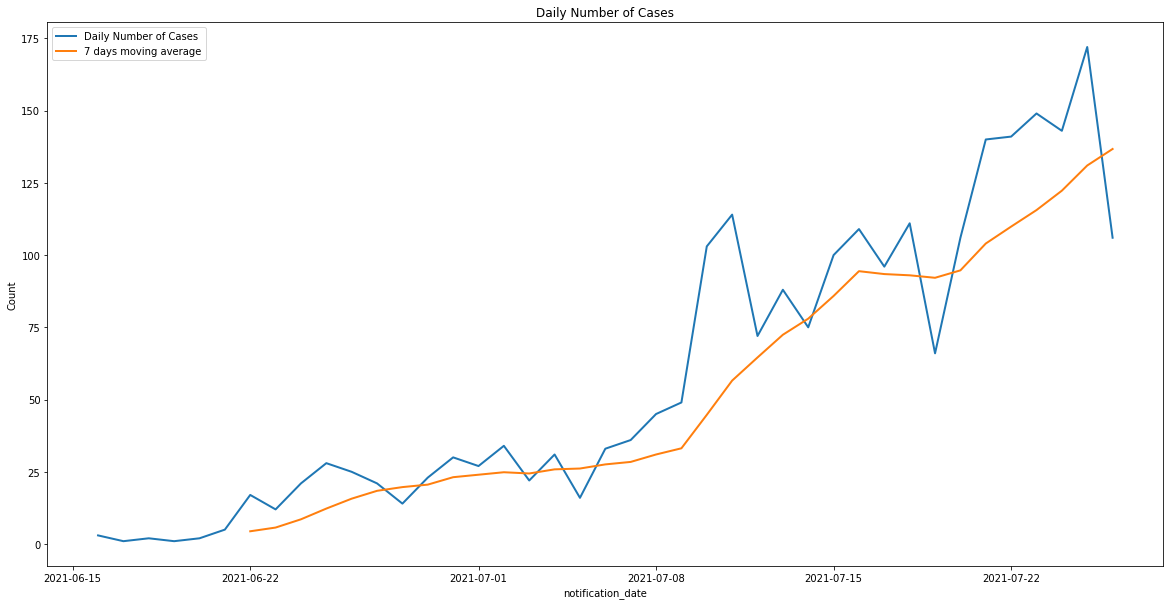

In [166]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="notification_date", y="Count", data=cases_agg, ax=ax, label="Daily Number of Cases", linewidth=2)
ax = sns.lineplot(x="notification_date", y="Average", data=cases_agg, ax=ax, label="7 days moving average", linewidth=2)
ax.set_title("Daily Number of Cases")

Text(0, 0.5, 'Cumulative Number of Cases')

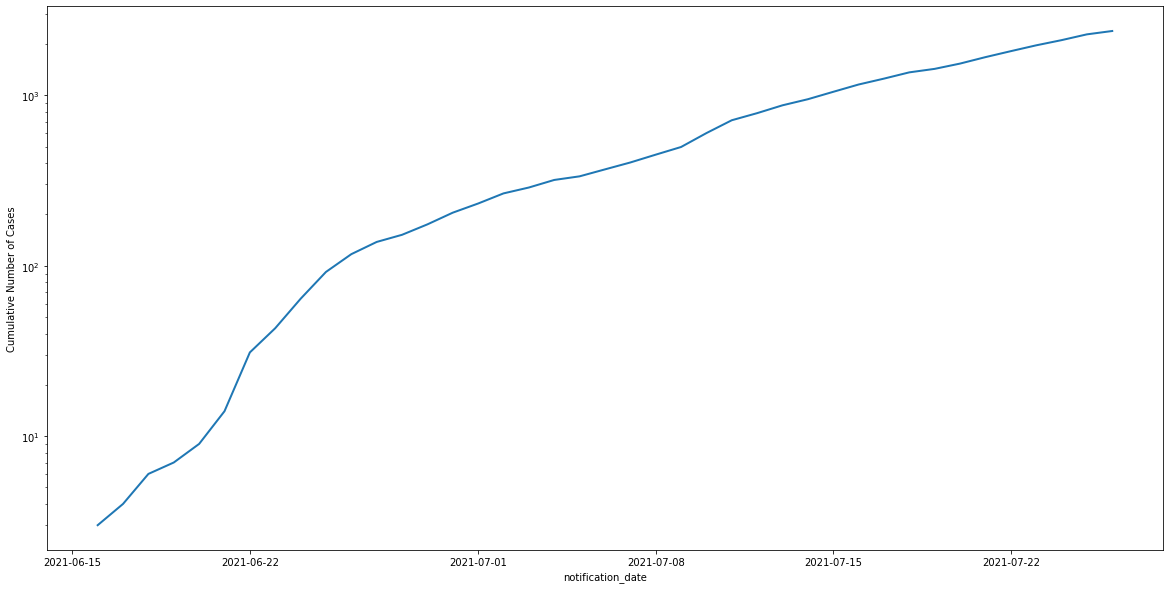

In [167]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="notification_date", y="Cumsum", data=cases_agg, ax=ax, linewidth=2)
ax.set_yscale("log")
ax.set_ylabel("Cumulative Number of Cases")

# Models

In [306]:
mask = cases_agg["Epidemiological Days"] >= 0
X = cases_agg.loc[mask, "Epidemiological Days"].values
y = cases_agg.loc[mask, "Cumsum"].values

# Bayesian Model 

In [273]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [286]:
mask = cases_agg["Epidemiological Days"] >= 0
X_train = cases_agg.loc[mask, "Epidemiological Days"].values
y_train = cases_agg.loc[mask, "Cumsum"].values

# Create PyMC3 context manager
with pm.Model() as model:
    t = pm.Data("x_data", X_train)
    cases = pm.Data("y_data", y_train)

    # Intercept - We fixed this at 100.
    a = pm.Normal("a", mu=100, sigma=10)

    # Slope - Growth rate: 0.2 is approx value reported by others
    b = pm.Normal("b", mu=0.2, sigma=0.5)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)

    trace = pm.sample()
    post_Pred = pm.sample_posterior_predictive(trace)

/tmp/ipykernel_779/3274948640.py:25: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


/tmp/ipykernel_779/851248946.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/vscode/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


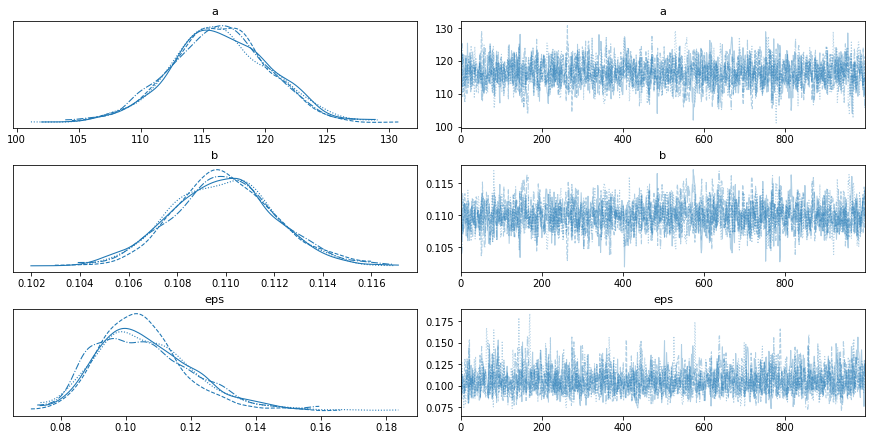

In [287]:
pm.traceplot(trace)
plt.show()

In [288]:
pm.summary(trace).round(2)

/home/vscode/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,116.37,4.01,109.25,124.21,0.1,0.07,1591.0,1547.0,1.00
b,0.11,0.00,0.11,0.11,0.0,0.00,1533.0,1377.0,1.00
eps,0.11,0.02,0.08,0.13,0.0,0.00,1920.0,1990.0,1.01


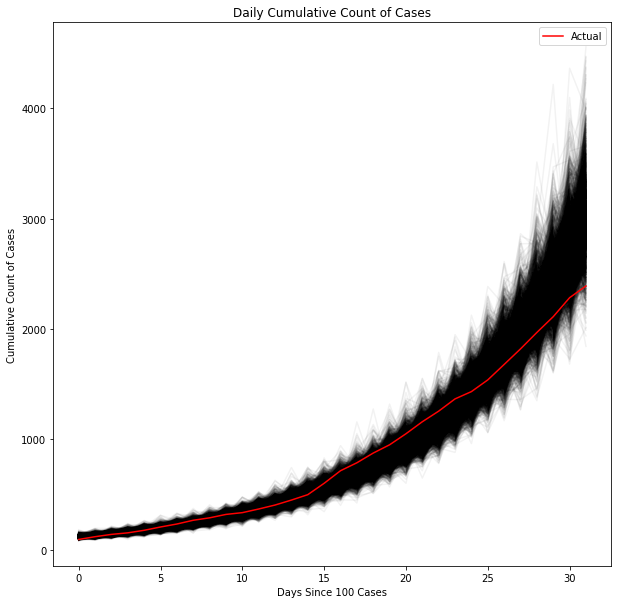

In [356]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(cases_agg.loc[mask, "Epidemiological Days"], post_Pred["cases"].T, color="k", alpha=0.05)
ax.plot(cases_agg.loc[mask, "Epidemiological Days"], cases_agg.loc[mask, "Cumsum"], color="r", label="Actual")
# ax.set_yscale("log")
ax.set(xlabel="Days Since 100 Cases", ylabel="Cumulative Count of Cases", title="Daily Cumulative Count of Cases")
ax.legend()
# plt.show()

# Linear Model

In [337]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [347]:
model = LinearRegression()
model.fit(X_train.reshape(-1, 1), np.log(y_train))
y_pred = model.predict(X.reshape(-1, 1))
y_pred_test = model.predict(X_test.reshape(-1, 1))

In [350]:
r2 = r2_score(np.log(y_test), y_pred_test)
print("R2:", r2)

mse = mean_squared_error(np.log(y_test), y_pred_test)
print("MSE:", mse)

R2: 0.9851265104107635
MSE: 0.009868951506945226


In [370]:
from scipy import stats

def get_prediction_interval(y_true, y_pred, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction

    References:
        [1] https://towardsdatascience.com/prediction-intervals-in-linear-regression-2ea14d419981
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_true - y_pred)**2)
    stdev = np.sqrt(1 / (len(y_true) - 2) * sum_errs)
    
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    #generate prediction interval lower and upper bound
    lower, upper = y_pred - interval, y_pred + interval    
    
    return lower, upper

lower, upper = get_prediction_interval(np.log(y), y_pred)

/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/v

[Text(0, 0.5, 'Cumulative Number of Cases'),
 Text(0.5, 0, 'Days Since 100 Cases'),
 Text(0.5, 1.0, 'Estimation of Cumulative Number of Cases per Days Since 100 Cases')]

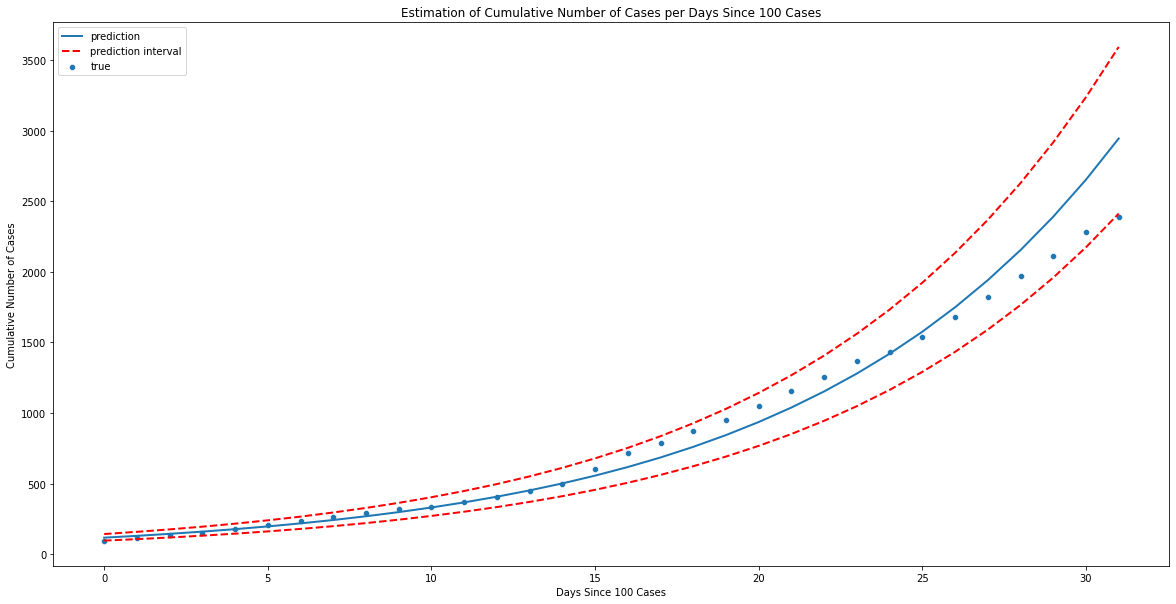

In [382]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(X, y, ax=ax, label='true')
ax = sns.lineplot(X, np.exp(y_pred), ax=ax, label='prediction', linewidth=2)
ax = sns.lineplot(X, np.exp(upper), ax=ax, linewidth=2, linestyle="--", color="r", label="prediction interval")
ax = sns.lineplot(X, np.exp(lower), ax=ax, linewidth=2, linestyle="--", color="r")
ax.set(ylabel="Cumulative Number of Cases", xlabel="Days Since 100 Cases", title="Estimation of Cumulative Number of Cases per Days Since 100 Cases")

In [260]:
import statsmodels.api as sm
logit = sm.Logit(y_train/max(y_train), X_train)
logit.fit().params

Optimization terminated successfully.
         Current function value: 0.687540
         Iterations 3


array([-0.00711789])

In [264]:
y_pred = logit.score(X_train.reshape(1, -1)) 

/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

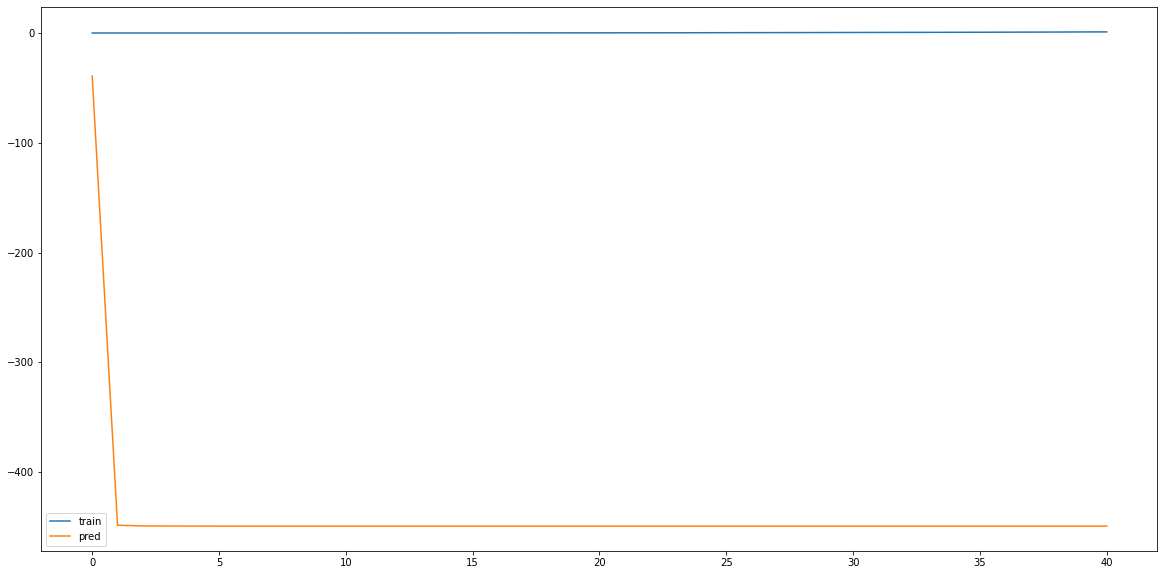

In [269]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(X_train, y_train/max(y_train), ax=ax, label='train')
sns.lineplot(X_train, y_pred.squeeze(), ax=ax, label='pred')

# References

[1] https://www.architecture-performance.fr/ap_blog/fitting-a-logistic-curve-to-time-series-in-python/

[2] https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python